# Description

This notebook contains a model to distinguish betwen grizzly, black and teddy bears

In [1]:
#This code is only here to check that your internet is enabled. It doesn't do anything else.

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [ ]:
# It's a good idea to ensure you're running the latest version of any libraries you need.

!pip install -Uqq fastai duckduckgo_search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 12.8 MB/s eta 0:00:00


In [ ]:
from duckduckgo_search import DDGS
from fastcore.all import *

ddgs = DDGS()

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddgs.images(term, max_results=max_images)).itemgot('image')

Searching for 'grizzly bear photos'


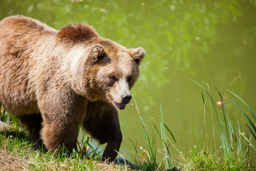

In [4]:
urls = search_images('grizzly bear photos', max_images=1)

from fastdownload import download_url
dest = 'grizzly.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [8]:
??download_url

In [6]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [7]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images(f'{o} bear photos', max_images=300)
        download_images(dest, urls=results)

Searching for 'grizzly bear photos'
Searching for 'black bear photos'
Searching for 'teddy bear photos'


In [9]:
??download_images

Our folder has image files, as we'd expect:

In [10]:
fns = get_image_files(path)
fns

(#726) [Path('bears/black/ca9dca23-369c-4b77-9b43-30dc05945a27.jpg'),Path('bears/black/80d159d7-2be7-4a2b-ab27-5f6ef1b9c057.jpg'),Path('bears/black/ef9044f6-3dcb-4a34-a00c-bd2e44cc0a09.jpg'),Path('bears/black/75d8d207-b12b-4aea-b85a-8d07582cbc89.jpg'),Path('bears/black/f9546204-364d-4120-a45a-582d2747cbbf.jpg'),Path('bears/black/3d549085-2462-40cd-8338-70f515460284.jpg'),Path('bears/black/755216db-a27e-4a2d-974d-4d0e8a87f5bb.jpg'),Path('bears/black/ac177035-effd-44c6-8284-06440c2139bd.jpg'),Path('bears/black/fde0508a-1f58-4e80-b833-62bea8d28d13.jpg'),Path('bears/black/b2eff3f0-aa0d-439a-9d7a-6cd2b727644e.jpg')...]

Often when we download files from the internet, there are a few that are corrupt. Let's check:

In [11]:
failed = verify_images(fns)
failed

(#50) [Path('bears/black/d6a98f3c-cf80-413c-ba3b-2721973de8de.JPG'),Path('bears/black/e70017c0-885d-4a0b-a051-5717467000e9.jpg'),Path('bears/black/b54d91f1-dc3a-4710-8053-45cf15ae1baf.jpg'),Path('bears/black/de55d7fe-a93e-4e66-9158-0ed35bae8ed2.jpg'),Path('bears/black/866019f2-8cfe-40ac-aaa9-df6182feacb7.jpg'),Path('bears/black/9e99c104-d684-4ea5-b5cd-4997cb935b46.jpg'),Path('bears/black/84f363f1-5847-4b7c-8403-a029a18e6c12.jpg'),Path('bears/black/12f810be-5537-4a5d-a6f6-7fc1de4dd40e.jpg'),Path('bears/black/96fbafc8-4df5-4256-bbe4-d694120e3db3.jpg'),Path('bears/black/601b124b-474e-4570-92a5-5034f14817b5.jpg')...]

In [12]:
len(failed)

50

To remove all the failed images, you can use unlink on each of them. Note that, like most fastai functions that return a collection, verify_images returns an object of type L, which includes the map method. This calls the passed function on each element of the collection:

In [13]:
failed.map(Path.unlink);

## From Data to DataLoaders

By default, Resize uses the cropping technique to bring the image in the desired shape

In [14]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [15]:
dls = bears.dataloaders(path)

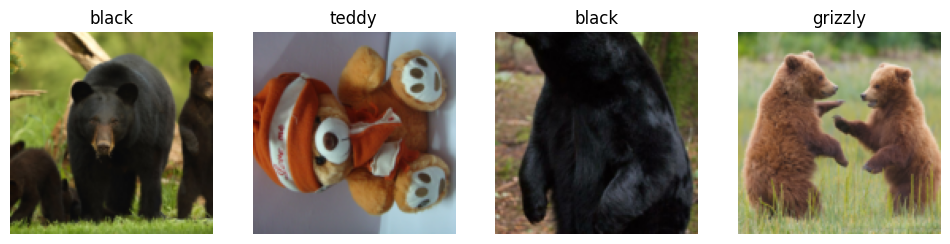

In [16]:
dls.valid.show_batch(max_n=4, nrows=1)

We can also squish the image to remove loss of image information. But the images can get thin/thick

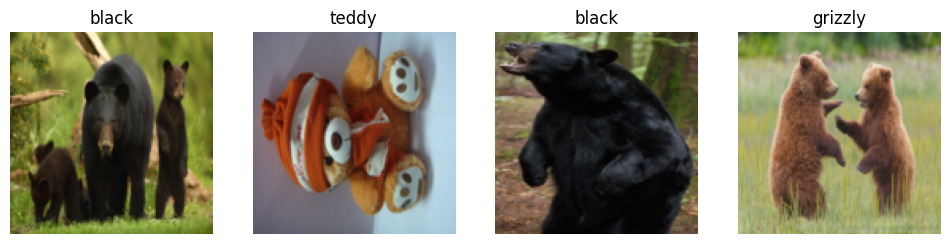

In [17]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

We can pad the image maintaining the aspect ratio of the original image.

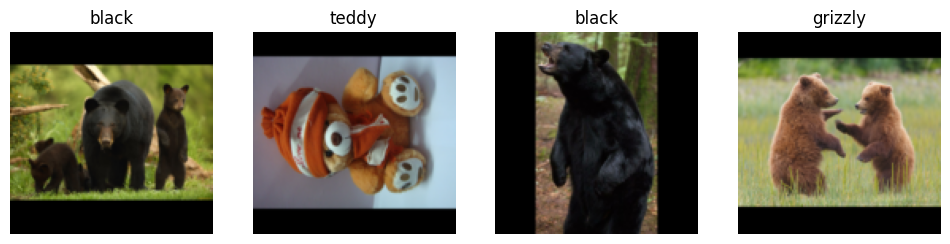

In [18]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

RandomResizedCrop is a type of image data augmentation where a crop of random size of the original size and a random aspect ratio of the original aspect ratio is made. This crop is finally resized to given size.

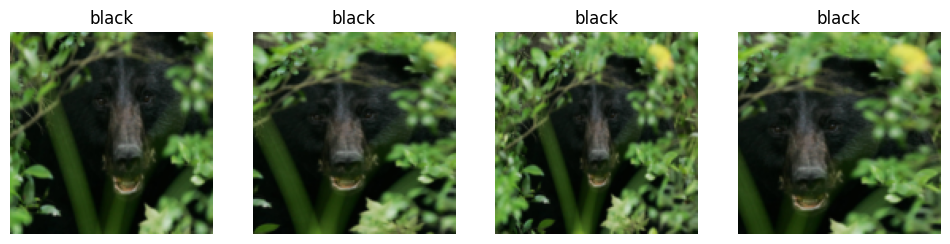

In [19]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [34]:
??dls

In [24]:
len(dls.train)

8

In [26]:
len(dls.valid)

3

In [37]:
??RandomResizedCrop

### Data Augmentation

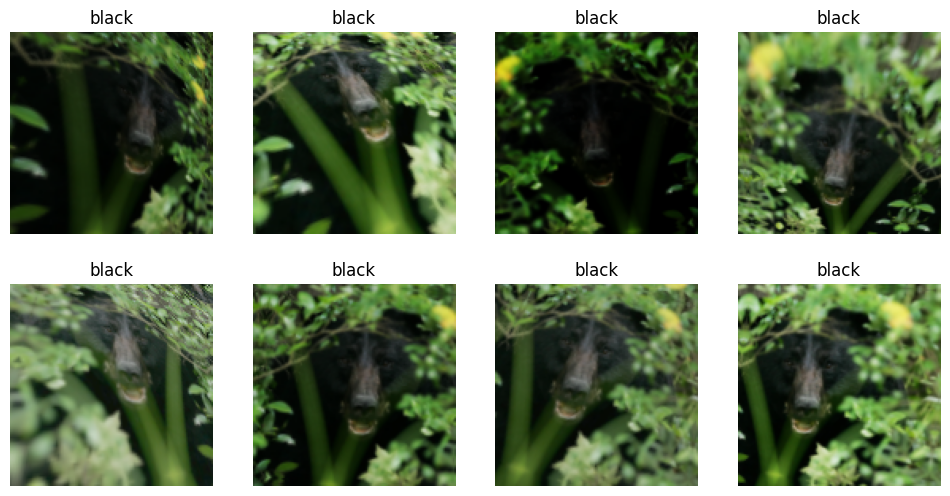

In [35]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2)) # means double the no of augmentations
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [36]:
len(dls.train)

8

## Training Your Model, and Using It to Clean Your Data

In [42]:
path

Path('bears')

In [44]:
len(get_image_files(path))

676

In [46]:
for o in bear_types:
  print(o)
  dest = (path/o)
  print(len(get_image_files(dest)))

grizzly
228
black
233
teddy
215


In [47]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

dls = bears.dataloaders(path)

In [48]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

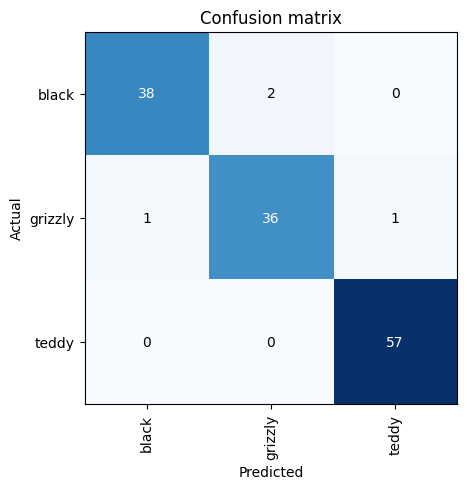

In [49]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

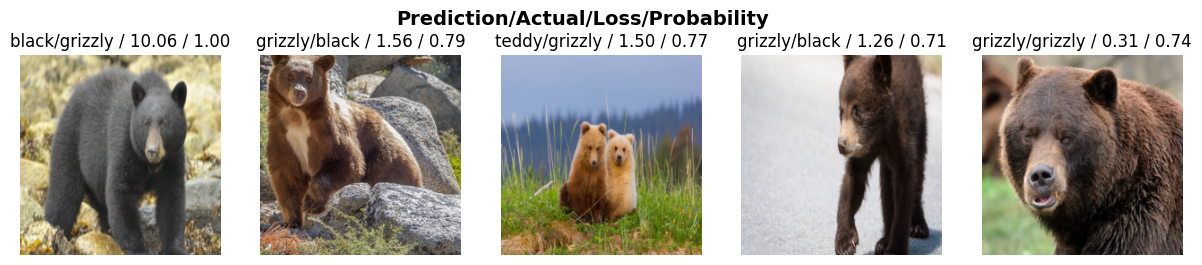

In [51]:
interp.plot_top_losses(5, nrows=1)

In [53]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [54]:
# hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [55]:
for o in bear_types:
  print(o)
  dest = (path/o)
  print(len(get_image_files(dest)))

grizzly
228
black
233
teddy
213


In [56]:
learn.export('model.pkl')

In [57]:
learn.dls.vocab

['black', 'grizzly', 'teddy']